
# Clasificación de Imágenes de Animales

**Objetivo**: Entrenar un modelo de redes neuronales convolucionales (CNN) para clasificar imágenes de animales utilizando un dataset organizado en subdirectorios.

El dataset contiene imágenes organizadas por carpetas, donde cada carpeta representa una categoría (e.g., `antelope`, `bear`). Esta libreta está estructurada de la siguiente manera:

1. Carga del dataset y preprocesamiento de las imágenes.
2. Construcción de un modelo de CNN utilizando TensorFlow/Keras.
3. Entrenamiento del modelo y ajuste de hiperparámetros.
4. Evaluación del rendimiento del modelo con métricas y visualizaciones.


In [66]:

# Importando las bibliotecas necesarias
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras import layers


## Parámetros Generales

Aquí definimos los parámetros de entrenamiento como `BATCH_SIZE`, `EPOCHS` y la tasa de aprendizaje (`LEARNING_RATE`), que hacen que sea fácil ajustar los hiperparámetros sin necesidad de modificar otras partes del código.

In [67]:
# Parámetros generales del entrenamiento
BATCH_SIZE = 32
EPOCHS = 50


## Carga del Dataset

El dataset está organizado en subdirectorios dentro de `animals/animals`. Cada subdirectorio corresponde a una categoría de animal.


In [68]:

# Ruta del dataset (ajustar según la ubicación real)
base_path = "./animals/animals"  # Directorio raíz de las imágenes

# Explorando las categorías disponibles
categories = os.listdir(base_path)
print(f"Categorías detectadas: {len(categories)}")
print(categories[:10])  # Mostrando las primeras 10 categorías como ejemplo

# Cargar modelo .keras
model = keras.models.load_model('model.keras')

Categorías detectadas: 10
['bear', 'cat', 'dog', 'duck', 'goat', 'lobster', 'panda', 'parrot', 'penguin', 'raccoon']



## Preprocesamiento de las Imágenes

Normalizamos las imágenes y aplicamos aumentación de datos para mejorar la generalización del modelo.


In [69]:
# Generador de imágenes con aumentación
image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Separar un porcentaje para validación
)

# Generadores de datos para entrenamiento y validación
train_data = image_gen.flow_from_directory(
    base_path,
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = image_gen.flow_from_directory(
    base_path,
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 480 images belonging to 10 classes.
Found 120 images belonging to 10 classes.


## Creació del model

In [70]:
model = Sequential()

model.add(layers.Flatten(input_shape=(150, 150, 3)))  # Update the input shape

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='relu'))  # Update the number of units to match the number of classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, validation_data=val_data, epochs=EPOCHS, batch_size=BATCH_SIZE)

C:\Users\mariodm1\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\mariodm1\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - accuracy: 0.1194 - loss: 7.4246 - val_accuracy: 0.1000 - val_loss: 7.5356
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.1174 - loss: 7.0502 - val_accuracy: 0.1000 - val_loss: 7.5233
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.0988 - loss: 7.2900 - val_accuracy: 0.1083 - val_loss: 7.5144
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.1167 - loss: 6.8511 - val_accuracy: 0.1667 - val_loss: 7.5141
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.1571 - loss: 7.2416 - val_accuracy: 0.1667 - val_loss: 7.5123
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.1242 - loss: 7.4300 - val_accuracy: 0.1500 - val_loss: 7.5124
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.1039 - loss: 7.5816 - val_accuracy: 0.2000 - val_loss: 7.5096
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.1029 - loss: 7.6073 - val_accuracy: 0.

KeyboardInterrupt: 

## Evaluar el entrenamiento

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.1915 - loss: 6.3714

Precisión en el conjunto de test: 0.2000
Pérdida en el conjunto de test: 6.1253


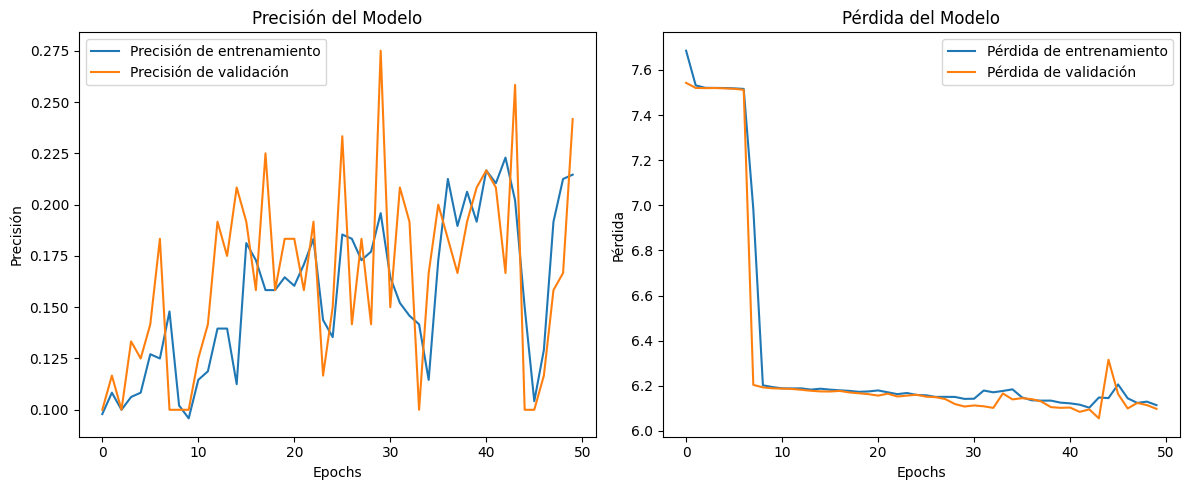


Posible Underfitting: precisión de validación por debajo del 60%.


In [ ]:
test_loss, test_accuracy = model.evaluate(val_data)

# Resultados de entrenamiento
print(f'\nPrecisión en el conjunto de test: {test_accuracy:.4f}')
print(f'Pérdida en el conjunto de test: {test_loss:.4f}')

# Gráfica de precisión y pérdida
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión del Modelo')
plt.xlabel('Epochs')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida del Modelo')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

# Análisis de overfitting/underfitting basado en la diferencia entre entrenamiento y validación
if history.history['accuracy'][-1] - history.history['val_accuracy'][-1] > 0.2:
    print("\nPosible Overfitting detectado: gran diferencia entre precisión de entrenamiento y validación.")
elif history.history['val_accuracy'][-1] < 0.6:
    print("\nPosible Underfitting: precisión de validación por debajo del 60%.")
else:
    print("\nEl modelo parece estar entrenado correctamente.")

In [ ]:
# Predecir una imagen
img = keras.preprocessing.image.load_img(
    "./animals/animals/parrot/0b2a1e349a.jpg", target_size=(150, 150)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f}% confidence."
    .format(categories[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
This image most likely belongs to dog with a 100.00% confidence.


## Guardar el modelo

In [ ]:
model.save('model.keras')